In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Set device
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
now = datetime.now()

start = datetime(now.year-10, now.month, now.day)
end = datetime(now.year, now.month, now.day)

In [5]:
ticker = "AAPL"
df = yf.download(ticker, start, end)
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
df['MA_100'] = df.Close.rolling(100).mean()
df['MA_200'] = df.Close.rolling(200).mean()

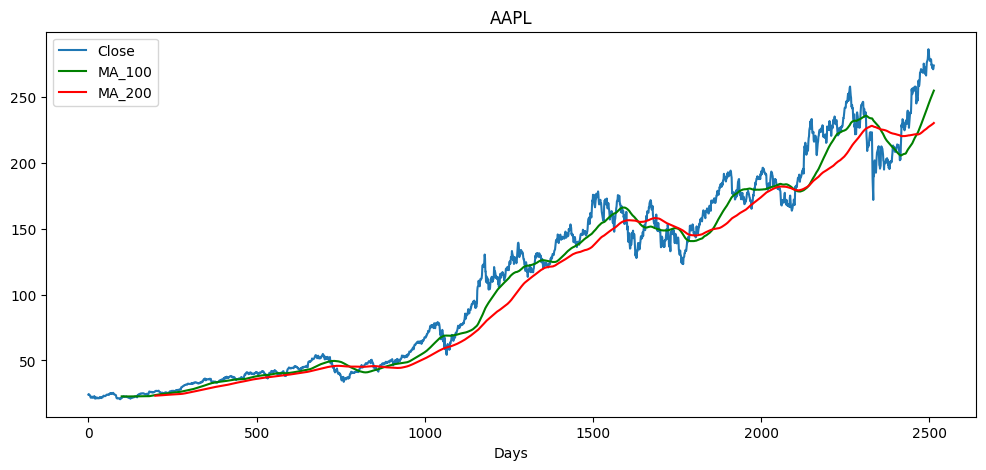

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.plot(df['MA_100'], 'g')
plt.plot(df['MA_200'], 'r')
plt.xlabel('Days')
plt.title(ticker)
plt.legend(['Close', 'MA_100', 'MA_200'])

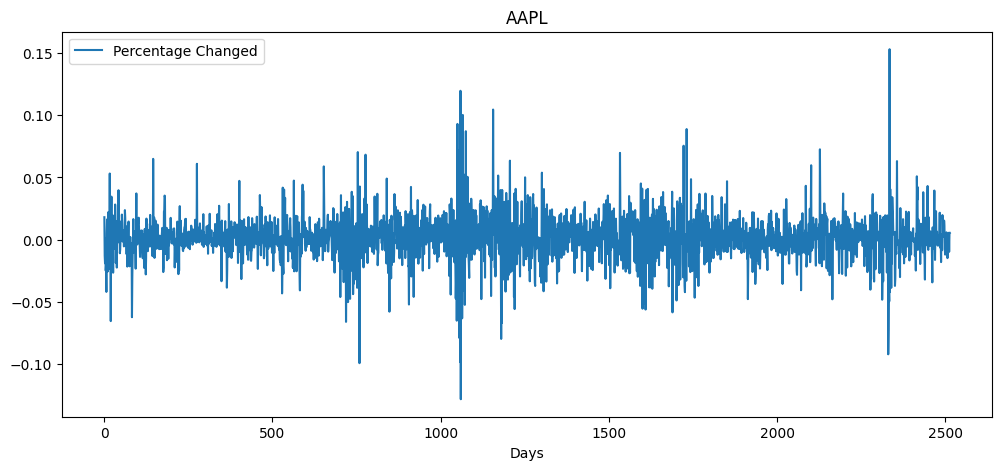

In [8]:
df['Percentage Changed'] = df.Close.pct_change()
plt.figure(figsize=(12,5))
plt.plot(df['Percentage Changed'])
plt.xlabel('Days')
plt.title(ticker)
plt.legend(['Percentage Changed'])

In [9]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = scaler.fit_transform(data_training)

In [13]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)

In [14]:
# Define PyTorch LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)

        # Take only the last time step output
        out = out[:, -1, :]

        # Fully connected layers
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = LSTMModel().to(device)

In [15]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# Training loop
epochs = 50
batch_size = 32

In [17]:
dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.6f}')

Epoch [10/50], Loss: 0.000606
Epoch [20/50], Loss: 0.000413
Epoch [30/50], Loss: 0.000356
Epoch [40/50], Loss: 0.000280
Epoch [50/50], Loss: 0.000206


In [19]:
# Prepare test data
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.fit_transform(final_df)

In [20]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Convert to PyTorch tensors
x_test = torch.FloatTensor(x_test).to(device)

In [21]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu().numpy()

# Inverse transform predictions
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [22]:
# Calculate metrics
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_test))

print(f"\nTest Metrics:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")


Test Metrics:
RMSE: $3.83
MAE: $2.72


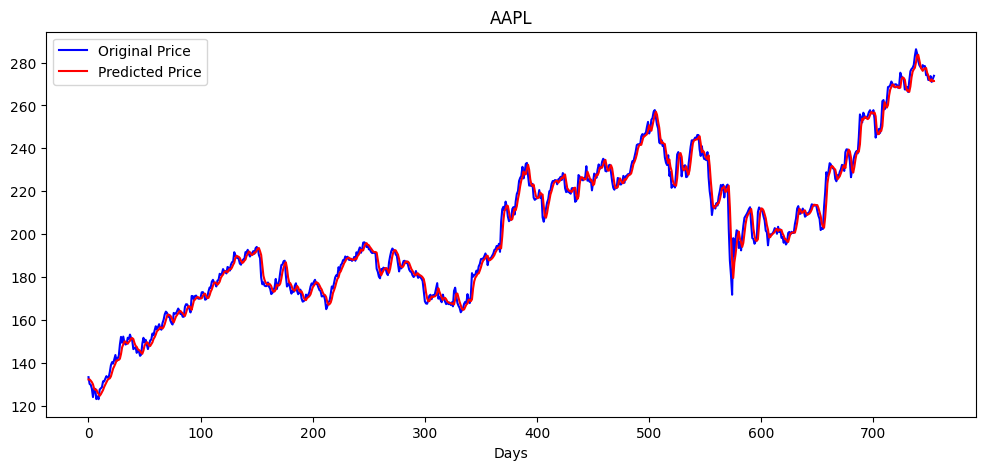

In [23]:
# Plot results
plt.figure(figsize=(12,5))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_pred, 'r', label='Predicted Price')
plt.xlabel('Days')
plt.title(ticker)
plt.legend()
plt.show()